# Convolutional VAE for the OASIS dataset of 2D brain scan images

This notebook is based on the TensorFlow guide for CVAEs provided at https://www.tensorflow.org/tutorials/generative/cvae.

This was completed as a way to practice working with images in TensorFlow Datasets, to try out GradientTape to define a training loop and to use data in Google Drive to train inside of Google Colab.

The script below relies on the OASIS dataset being loaded into a Google Drive account.

In [ ]:
import glob
import tensorflow as tf
import numpy as np
import PIL
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from IPython import display
from google.colab import drive
import pathlib

In [ ]:
# This will provide a link to apply a code to access Drive
drive.mount("data")

Drive already mounted at data; to attempt to forcibly remount, call drive.mount("data", force_remount=True).


In [ ]:
# Update to OASIS dataset location in Drive
train_location = 'data/My Drive/BCompSc/COMP3710/prac02/keras_png_slices_data/keras_png_slices_train/*'
test_location = 'data/My Drive/BCompSc/COMP3710/prac02/keras_png_slices_data/keras_png_slices_test/*'

In [ ]:
train_images = glob.glob(train_location)
train_images.sort()

test_images = glob.glob(test_location)
test_images.sort()

In [ ]:
train_size = len(train_images)
test_size = len(test_images)
batch_size = 32

img_width = 256
img_height = 256
img_channels = 1

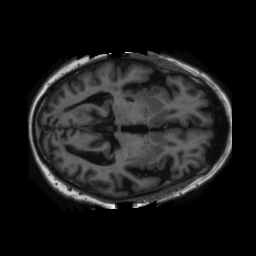

In [ ]:
PIL.Image.open(test_images[0])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [ ]:
def load_img(file_name):
  """Used as the map function below to load images from file lists"""
  img = tf.io.read_file(file_name)
  img = tf.io.decode_png(img) / 255
  return img

In [ ]:
# preprocess images
train_dataset = train_dataset.map(load_img)
test_dataset = test_dataset.map(load_img)

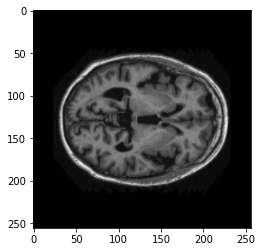

In [ ]:
for i in train_dataset.take(1):
  i = i[:, :, 0]
  plt.figure()
  plt.imshow(i, cmap='gray')

In [ ]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
class CVAE(tf.keras.Model):
    """Convolutional Variational AutoEndoder"""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential(
            [
                InputLayer(input_shape=(256, 256, 1)),
                Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
                Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
                Flatten(),
                Dense(latent_dim + latent_dim), 
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                InputLayer(input_shape=(latent_dim,)),
                Dense(units=64*64*32, activation=tf.nn.relu),
                Reshape((64, 64, 32)), 
                Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'), 
                Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), 
                Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'), 
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar 

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean 
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimiser = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return - tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimiser):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 20
latent_dim = 2
num_examples = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def get_images(model, epoch, test_sample):
    """Collect example images from the epoch and show"""
    mean, logvar = model.encode(test_sample) 
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
assert batch_size > num_examples
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples, :, :, :]

Epoch: 20, Test set ELBO: -17105.9296875, time for current epoch: 60.59203624725342


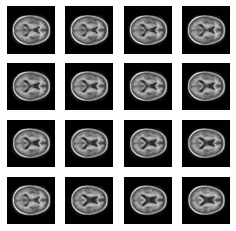

In [ ]:
get_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimiser)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    get_images(model, epoch, test_sample)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

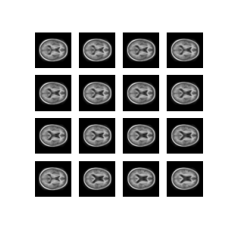

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')

In [2]:
def plot_latent_images(model, n, digit_size=256):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(16, 16))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

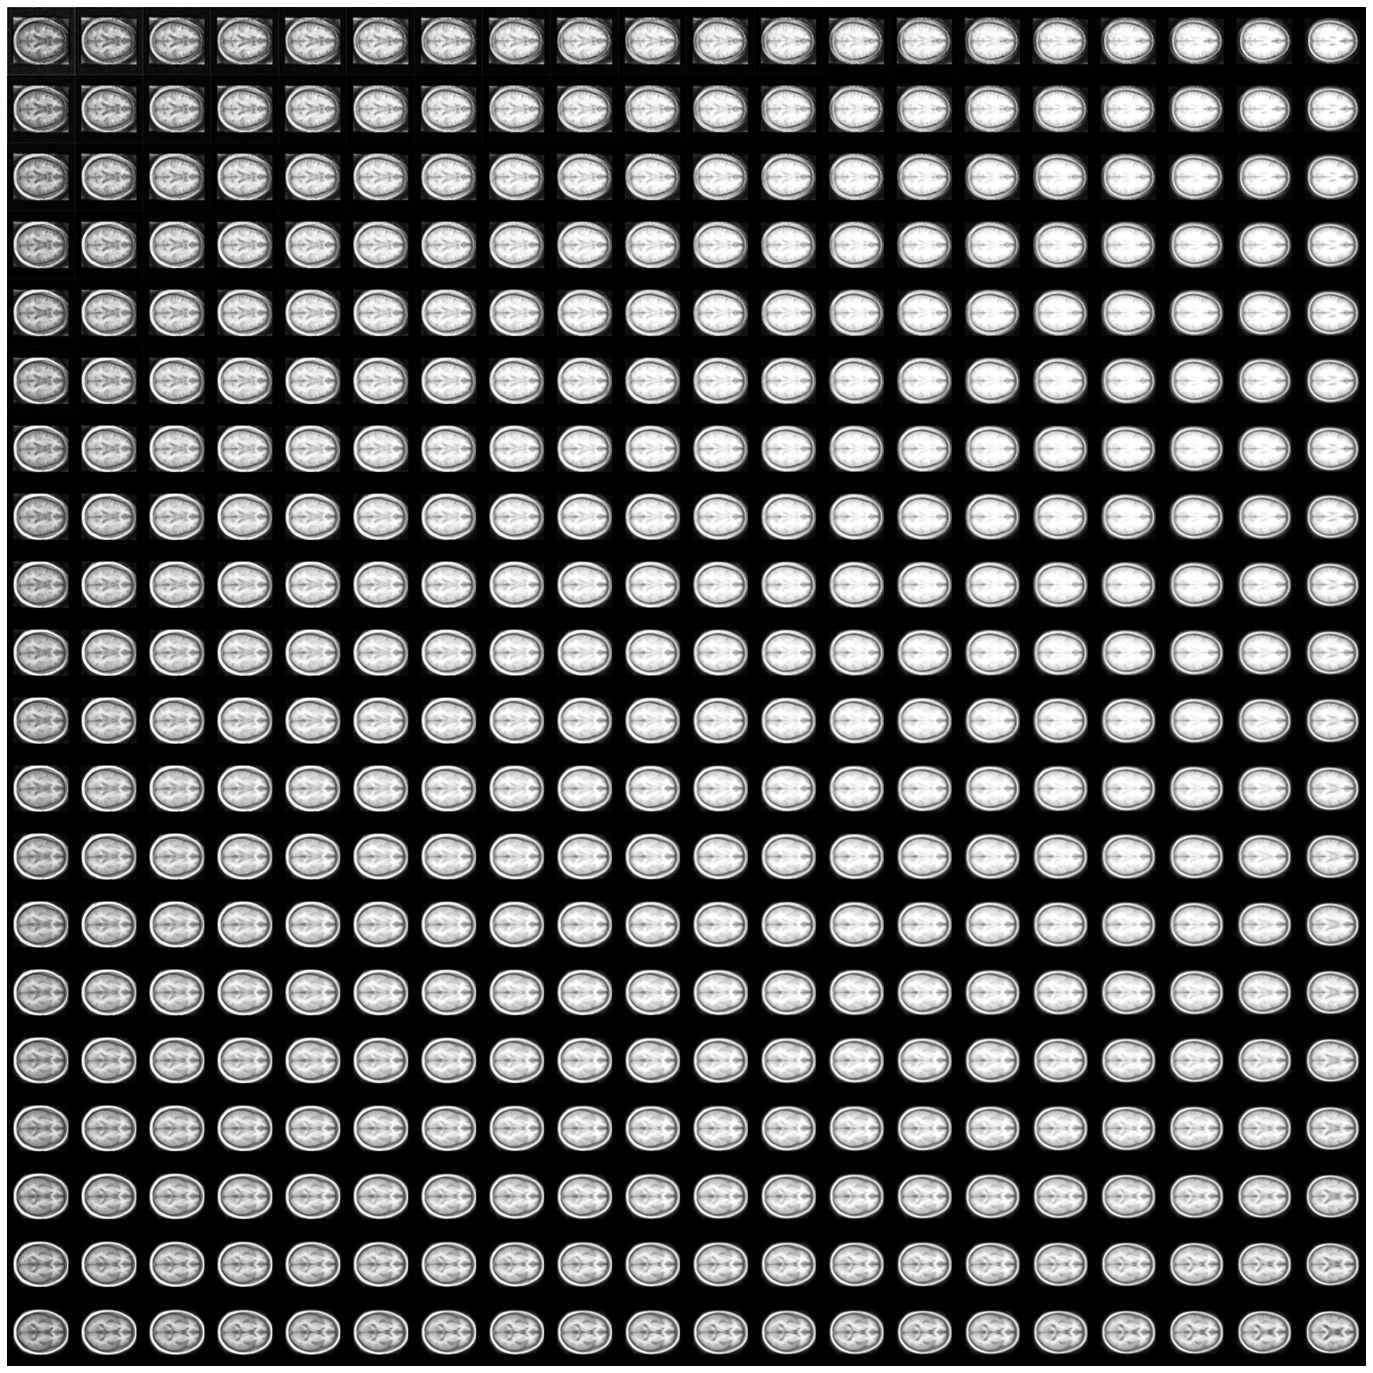

In [ ]:
plot_latent_images(model, 20)